In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.environ["PETSC_DIR"]+'/lib/petsc/bin/')
from PetscBinaryIO import PetscBinaryIO

In [3]:
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=130)

In [4]:
from case import *
dt = 0.02

In [5]:
d = np.loadtxt('3-FrequencyResponse/j006_n013_optimal_gains.txt', unpack=True)
ω, j, nP = d[0,:].real, d[1,:].real.astype(int), d[2,0].real.astype(int)
G, e = d[4,:], d[5,:].real

In [6]:
freqs = [0, 2]

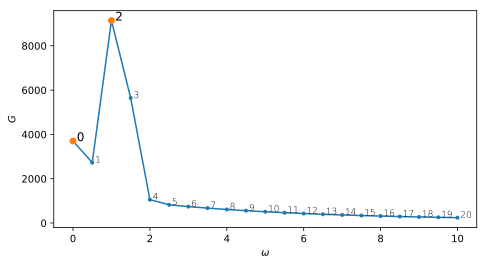

In [7]:
plt.figure(figsize=(19/2.5, 10/2.5))
plt.plot(ω, G, '.-')
plt.plot(ω[freqs], G[freqs], 'o')
for k, ωk in enumerate(ω):
    plt.text(ωk, G[k], ' %d'%k, color='0',
             va='baseline', ha='left', fontsize=12 if k in freqs else 9,
             weight='normal' if k in freqs else 'light')

plt.xlabel(r'$\omega$')
plt.ylabel(r'$G$');

In [8]:
s1 = ib.stretching(192, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
s2 = ib.stretching(96, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
x = np.concatenate([-s2[::-1], s1[1:]])

s = ib.stretching(22*3//2 + 1, 0.04, 0.25, int(0.65/0.04), 16, 16, 0.04)
y0 = np.concatenate([-s[::-1], s[1:]])
Ly = y0[-1] - y0[0]
y = np.concatenate([y0,] + [y0[1:] + k*Ly for k in range(1, 13)])

In [9]:
yu = 0.5*(y[1:] + y[:-1])
xu = x[1:-1]

n1 = len(y0) - 1

n, m = (len(y) - 1, len(x)-1)

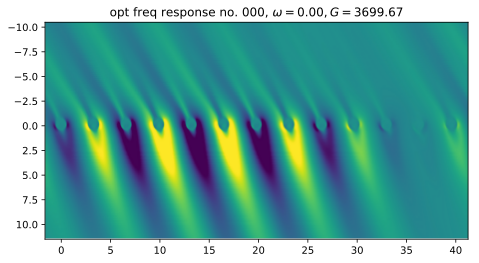

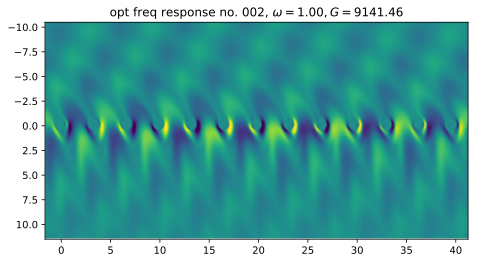

In [10]:
xmin, xmax = -1, 2
ymin, ymax = y[0], y[-1]

for freq in freqs:
    jP = j[freq]
    ρk = np.exp(1j*jP*2*np.pi/nP)
    
    _vec = PetscBinaryIO().readBinaryFile('3-FrequencyResponse/j%03d_n%03d_w%05.2f_f_i%03d.dat'%(jP, nP, ω[freq], 0))[0]
    vec = np.empty(_vec.shape, dtype=np.complex)
    vec[:]=_vec[:]
    del _vec
    
    iRq = vec[:n1*(m-1) + n1*m]

    u = iRq[:n1*(m-1)].reshape((n1, m-1))
    v = iRq[n1*(m-1):].reshape((n1, m))
    #ϕ = vec[n1*(m-1) + n1*m:n1*(m-1) + 2*n1*m].reshape((n1, m))
    
    u = np.vstack([ρk**(k-1)*u for k in range(nP)])
    v = np.vstack([ρk**(k-1)*v for k in range(nP)])
    #ϕ = np.vstack([ρk**(k-1)*ϕ for k in range(nP)])
    
    plt.figure(figsize=(19/2.5, 10/2.5))
    plt.pcolormesh(yu, xu, u.T.real, rasterized=True, shading='gouraud', vmin=0.5*np.min(u.real), vmax=0.5*np.max(u.real))
    #plt.plot(np.asarray(np.split(eta, nP)).T, np.asarray(np.split(xi, nP)).T, 'k', lw=1);
    plt.axis('equal')
    plt.title(r'opt freq response no. %03d, $ω = %.2f, G= %.2f$'%(freq, ω[freq], G[freq]))
    plt.ylim(xmax, xmin)
    plt.xlim(ymin, ymax)